In [1]:
!cat /usr/local/cuda/version.txt

cat: /usr/local/cuda/version.txt: No such file or directory


In [2]:
import numpy as np
import pickle
import torch
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#from tsnecuda import TSNE

# Get the interactive Tools for Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9.5, 6]

plt.style.use('ggplot')

In [3]:
class Vocabulary(object):
    def __init__(self, pad_token='<pad>', unk_token='<unk>', eos_token='<eos>'):
        self.token2idx = {}
        self.idx2token = []
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.eos_token = eos_token
        if pad_token is not None:
            self.pad_index = self.add_token(pad_token)
        if unk_token is not None:
            self.unk_index = self.add_token(unk_token)
        if eos_token is not None:
            self.eos_index = self.add_token(eos_token)

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def get_index(self, token):
        if isinstance(token, str):
            return self.token2idx.get(token, self.unk_index)
        else:
            return [self.token2idx.get(t, self.unk_index) for t in token]

    def __len__(self):
        return len(self.idx2token)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filename):
        with open(filename, 'rb') as f:
            self.__dict__.update(pickle.load(f))

We will use the vocabulary computed by the CBOW Preprocessing notebook (cbow-preprocessing), and the word vectors computed by the CBOW Training notebook (cbow-vectors)

In [4]:
DATASET_VERSION = 'ca-100'
CBOW_VOCABULARY_ROOT = f'../input/cbow-preprocessing/data/{DATASET_VERSION}'
CBOW_VECTORS_ROOT = f'../input/cbow-training/data/{DATASET_VERSION}'

In [5]:
dict = f'{CBOW_VOCABULARY_ROOT}/ca.wiki.train.tokens.nopunct.dic'
counter = pickle.load(open(dict, 'rb'))
words, values = zip(*counter.most_common(5000))
print('Most frequent Catalan words')
print(words[:10])
print(values[:10])

Most frequent Catalan words
('de', 'la', 'i', 'a', 'el', 'l', 'que', 'd', 'en', 'del')
(4751505, 2822635, 2358612, 2039892, 1839386, 1386253, 1358265, 1258761, 1205524, 1100486)


**Zipf's law of words**. Zipf's law was originally formulated in terms of quantitative linguistics, stating that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.

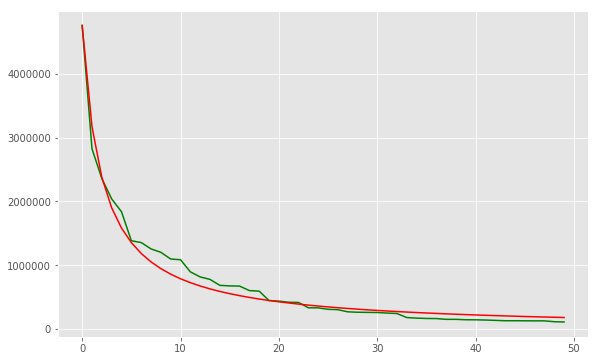

In [6]:
_ = plt.plot(values[:50], 'g', 2*values[0]/np.arange(2,52), 'r')

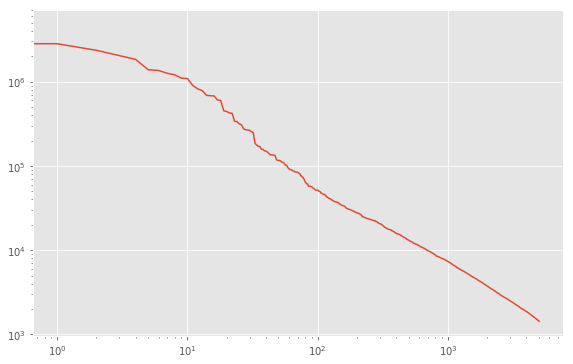

In [7]:
_ = plt.loglog(values)
plt.show()

**Benford's law**, also called the Newcomb–Benford law, the law of anomalous numbers, or the first-digit law, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data.

Counter({1: 1682, 2: 1385, 3: 664, 4: 419, 5: 290, 6: 176, 7: 164, 8: 126, 9: 94})


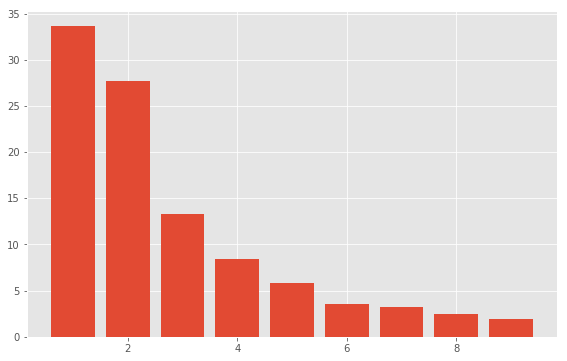

In [8]:
from collections import Counter
benford = Counter(int(str(item[1])[0]) for item in counter.most_common(5000))
print(benford)
percentage = np.array(list(benford.values()), dtype=np.float)
percentage /= percentage.sum()
_ = plt.bar(list(benford.keys()), percentage*100)

In [9]:
modelname = f'{CBOW_VECTORS_ROOT}/{DATASET_VERSION}.pt'
state_dict = torch.load(modelname, map_location=torch.device('cpu'))

In [10]:
state_dict.keys()

odict_keys(['emb.weight', 'lin.weight'])

In [11]:
input_word_vectors = state_dict['emb.weight'].numpy()
output_word_vectors = state_dict['lin.weight'].numpy()

In [12]:
token_vocab = Vocabulary()
token_vocab.load(f'{CBOW_VOCABULARY_ROOT}/ca.wiki.vocab')

In [13]:
class WordVectors:
    def __init__(self, vectors, vocabulary):
        self.vectors = vectors
        self.vocabulary = vocabulary
        
    def get_vector(self, word):
        return self.vectors[self.vocabulary.get_index(word)]
        
    def cosine_distance(self, vect_a, vect_b):
        return np.dot(vect_a, vect_b) / (norm(vect_a)*norm(vect_b))
    
    def most_similar(self, word = '', word_vect = None, invalid_words = None, topn = 10):
        invalid_words = (word) if invalid_words is None else invalid_words
        word_vect = self.get_vector(word) if word_vect is None else word_vect
        cosine_dict = {}
        for item in self.vocabulary.token2idx:
            if item not in invalid_words:
                item_vect = self.get_vector(item)
                cosine_dict[item] = self.cosine_distance(word_vect, item_vect)
        cosine_dict = sorted(cosine_dict.items(), key = lambda x: -x[1])
        words_list = [(item[0], item[1]) for item in cosine_dict]
        return words_list[:topn]
    
    def analogy(self, x1, x2, y1, topn = 8, keep_all = False):
        x1_vect = self.get_vector(x1)
        x2_vect = self.get_vector(x2)
        y1_vect = self.get_vector(y1)
        dangling_word_vect = (x2_vect - x1_vect) + y1_vect
        remove_words = None if keep_all else (x1, x2, y1)
        return self.most_similar(word_vect = dangling_word_vect, invalid_words = remove_words, topn = topn)
        
    def closest_words_scatterplot(self, word, topn = 10, analogy = False):
        X = np.empty((0,100))
        if analogy:
            word_labels = word
            similar_words = self.analogy(word[0],word[1],word[2])
            X = np.append(X, [np.array(self.get_vector(word[0]))], axis=0)
            X = np.append(X, [np.array(self.get_vector(word[1]))], axis=0)
            X = np.append(X, [np.array(self.get_vector(word[2]))], axis=0)
        else:
            word_labels = word
            similar_words = self.most_similar(word[0])
            X = np.append(X, [np.array(self.get_vector(word[0]))], axis=0)
            
        for item in similar_words:
            word_vect = self.get_vector(item[0])
            word_labels.append(item[0])
            X = np.append(X, [np.array(word_vect)], axis=0)
            
        X_embedded = PCA(n_components = 2).fit_transform(X)
        x_coords = X_embedded[:, 0]
        y_coords = X_embedded[:, 1]
        plt.scatter(x_coords, y_coords)
        
        for label, x, y in zip(word_labels, x_coords, y_coords):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        if analogy:
            plt.plot(x_coords[0:2], y_coords[0:2], '--')
            plt.plot(x_coords[2:4], y_coords[2:4], '--')
        else:
            plt.plot(x_coords[0:2], y_coords[0:2], '--')
        plt.show()
        
    def clusters(self, C = 3):
        word_vectors = {}
        for word in words:
            # 'words' is a previous created tuple with the
            # 5000 most frequent words sorted decreasingly
            word_vectors[word] = self.get_vector(word)
        X = np.array(list(word_vectors.values()))
        
        X_embedded = PCA(n_components = 2).fit_transform(X)
        x_coords = X_embedded[:, 0]
        y_coords = X_embedded[:, 1]
        #plt.scatter(x_coords, y_coords)
        
        kmeans = KMeans(n_clusters = 3).fit(X_embedded)
        centroids = kmeans.cluster_centers_
        print(centroids)
        print(len(kmeans.labels_))
        
        plt.scatter(x_coords, y_coords, c = kmeans.labels_.astype(float), s = 50, alpha = 0.5)
        plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', s = 50)
        
        
        #i, j = np.where(np.isclose(X_embedded, centroids[0]))
        closest, _ = pairwise_distances_argmin_min(centroids, X_embedded)
        
        print(centroids[0])
        print(closest)
        for index in closest:
            plt.scatter(x_coords[index], y_coords[index], c = 'black', s = 50)
            point = words[index]
            print(point)
        
        #plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        #plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        #plt.show()
        #return(X_embedded)
        

In [14]:
model1 = WordVectors(input_word_vectors, token_vocab)
model2 = WordVectors(output_word_vectors, token_vocab)

[[-0.23853163 -2.002823  ]
 [-1.6347328   0.95251095]
 [ 1.6351684   0.5958419 ]]
5000
[-0.23853163 -2.002823  ]
[  20 2438 3855]
El
Rosselló
batalles


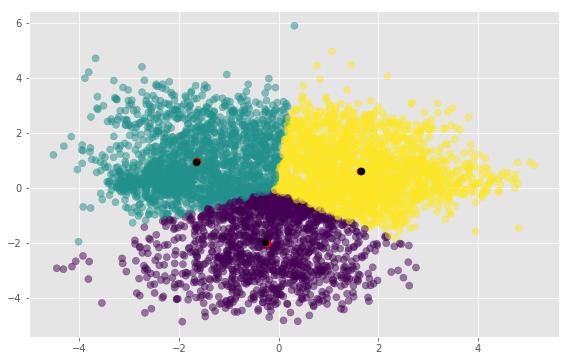

In [15]:
model1.clusters()

In [16]:
model1.most_similar('català')

[('valencià', 0.8437977),
 ('basc', 0.7916813),
 ('mallorquí', 0.7442791),
 ('gallec', 0.74309915),
 ('sard', 0.70627207),
 ('castellà', 0.67775935),
 ('lleidatà', 0.67494184),
 ('espanyol', 0.6728176),
 ('aragonès', 0.66094786),
 ('francès', 0.64962184)]

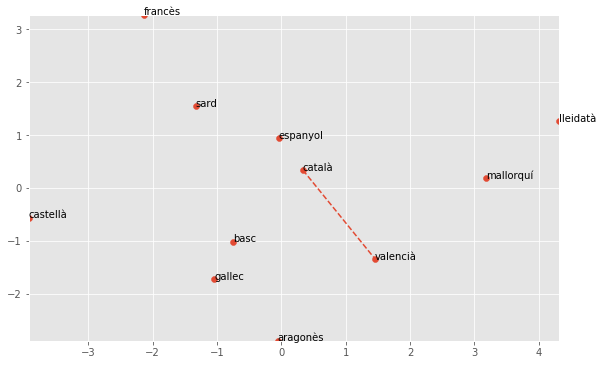

In [17]:
model1.closest_words_scatterplot(['català'])

In [18]:
model2.analogy('França', 'francès', 'Polònia')

[('polonès', 0.9593665),
 ('japonès', 0.95928997),
 ('rus', 0.9589016),
 ('neerlandès', 0.9584113),
 ('suec', 0.9510274),
 ('basc', 0.950369),
 ('hongarès', 0.95005536),
 ('turc', 0.94498354)]

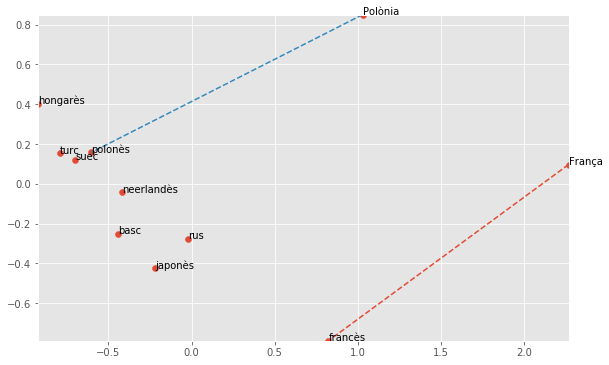

In [19]:
model2.closest_words_scatterplot(['França', 'francès', 'Polònia'], analogy = True)

In [20]:
print(
    model2.analogy('dilluns', 'dimarts', 'dimecres', 1),
    model2.analogy('un', 'dos', 'tres', 1),
    model2.analogy('dos', '2', 'tres', 1),
    model2.analogy('coneix', 'coneixia', 'viu', 1),
    model2.analogy('el', 'els', 'la', 1),
    sep='\n'
)

[('dijous', 0.959055)]
[('quatre', 0.88887227)]
[('3', 0.9796136)]
[('vivia', 0.95712376)]
[('les', 0.8842031)]


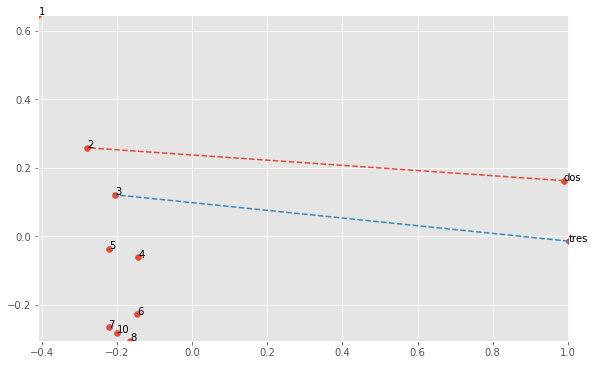

In [21]:
model2.closest_words_scatterplot(['dos', '2', 'tres'], analogy = True)